In [47]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
from tensorflow import keras
K = keras.backend

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

In [48]:
# To make the output stable across runs
tf.random.set_seed(42)
np.random.seed(42)

In [49]:
# Load the data
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'credit_card.csv'])
data = pd.read_csv(current_path + file)

In [50]:
# Create X matrix
dataX = data.copy().drop(['Class','Time'],axis=1)

# Create y Matrix
dataY = data['Class'].copy()

In [51]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
                                    dataX, dataY, test_size=0.33, 
                                    random_state=2018, stratify=dataY)

In [52]:
# Shape of data
print([x.shape for x in (X_train, X_test, y_train, y_test)])

[(190820, 29), (93987, 29), (190820,), (93987,)]


In [53]:
# Number of negative and positive examples
np.sum(y_train==0),np.sum(y_train==1)

(190490, 330)

In [54]:
# Suppress warnings
pd.set_option('mode.chained_assignment', None)

# Scale data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
X_train.loc[:,featuresToScale] = sX.fit_transform(X_train.loc[:,featuresToScale])
X_test.loc[:,featuresToScale] = sX.transform(X_test.loc[:,featuresToScale])

In [55]:
# Drop 90% of the labels from the training set
toDrop = y_train[y_train==1].sample(frac=0.90,random_state=2018)
X_train.drop(labels=toDrop.index,inplace=True)
y_train.drop(labels=toDrop.index,inplace=True)

In [56]:
# Check the number of fruadulant cases left after dropping 90% 
np.sum(y_train==0),np.sum(y_train==1)

(190490, 33)

In [57]:
# Calculate reconstruction error
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - 
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [58]:
# Plot results
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], 
                               preds['anomalyScore'])
    average_precision = average_precision_score( 
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], 
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

In [59]:
# Define new function to assess precision at a given recall threshold
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

In [60]:
# Create 5 k-fold sets
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

In [61]:
# LightGBM parameters
params_lightGB = {
    'task': 'train',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': -1,
    'num_threads':16
}

In [62]:
# Train and Evaluate Model
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, 
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), 
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index],   y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, 
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(
        X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print(f'Training Log Loss: {loglossTraining}')
    print(f'CV Log Loss: {loglossCV}')

c:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.00328814
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00501481
[3]	valid_0's binary_logloss: 0.00652752
[4]	valid_0's binary_logloss: 0.00970611
[5]	valid_0's binary_logloss: 0.00904848
[6]	valid_0's binary_logloss: 0.00841494
[7]	valid_0's binary_logloss: 0.00910741
[8]	valid_0's binary_logloss: 0.00910587
[9]	valid_0's binary_logloss: 0.00924833
[10]	valid_0's binary_logloss: 0.00919577
[11]	valid_0's binary_logloss: 0.00891503
[12]	valid_0's binary_logloss: 0.0108699
[13]	valid_0's binary_logloss: 0.0108043
[14]	valid_0's binary_logloss: 0.0107882
[15]	valid_0's binary_logloss: 0.0105259
[16]	valid_0's binary_logloss: 0.0105149
[17]	valid_0's binary_logloss: 0.0104953
[18]	valid_0's binary_logloss: 0.0104768
[19]	valid_0's binary_logloss: 0.0104584
[20]	valid_0's binary_logloss: 0.0104398
[21]	valid_0's binary_logloss: 0.0104107
[22]	valid_0's binary_logloss: 0.0103445
[23]	valid_0's binary_logloss: 0.0

c:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.00294785
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.000841905
[3]	valid_0's binary_logloss: 0.000757406
[4]	valid_0's binary_logloss: 0.000667338
[5]	valid_0's binary_logloss: 0.000543651
[6]	valid_0's binary_logloss: 0.000538745
[7]	valid_0's binary_logloss: 0.00053763
[8]	valid_0's binary_logloss: 0.000534695
[9]	valid_0's binary_logloss: 0.000532032
[10]	valid_0's binary_logloss: 0.000529072
[11]	valid_0's binary_logloss: 0.000526766
[12]	valid_0's binary_logloss: 0.000524395
[13]	valid_0's binary_logloss: 0.000522519
[14]	valid_0's binary_logloss: 0.000520684
[15]	valid_0's binary_logloss: 0.000452826
[16]	valid_0's binary_logloss: 0.000450802
[17]	valid_0's binary_logloss: 0.000449397
[18]	valid_0's binary_logloss: 0.000445891
[19]	valid_0's binary_logloss: 0.000444534
[20]	valid_0's binary_logloss: 0.00044271
[21]	valid_0's binary_logloss: 0.000441247
[22]	valid_0's binary_logloss: 0.000440362
[23]

c:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.00561895
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.0050821
[3]	valid_0's binary_logloss: 0.00451601
[4]	valid_0's binary_logloss: 0.00473456
[5]	valid_0's binary_logloss: 0.00471262
[6]	valid_0's binary_logloss: 0.00470073
[7]	valid_0's binary_logloss: 0.00469119
[8]	valid_0's binary_logloss: 0.00468858
[9]	valid_0's binary_logloss: 0.00468267
[10]	valid_0's binary_logloss: 0.00468025
[11]	valid_0's binary_logloss: 0.00471679
[12]	valid_0's binary_logloss: 0.00471517
[13]	valid_0's binary_logloss: 0.00471356
[14]	valid_0's binary_logloss: 0.00471046
[15]	valid_0's binary_logloss: 0.00470888
[16]	valid_0's binary_logloss: 0.00470661
[17]	valid_0's binary_logloss: 0.00470419
[18]	valid_0's binary_logloss: 0.00470263
[19]	valid_0's binary_logloss: 0.00470107
[20]	valid_0's binary_logloss: 0.00470618
[21]	valid_0's binary_logloss: 0.00470988
[22]	valid_0's binary_logloss: 0.00471246
[23]	valid_0's binary_lo

c:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.00322936
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00263632
[3]	valid_0's binary_logloss: 0.00260261
[4]	valid_0's binary_logloss: 0.00259908
[5]	valid_0's binary_logloss: 0.00269046
[6]	valid_0's binary_logloss: 0.00325352
[7]	valid_0's binary_logloss: 0.00314905
[8]	valid_0's binary_logloss: 0.00310218
[9]	valid_0's binary_logloss: 0.00307436
[10]	valid_0's binary_logloss: 0.00304972
[11]	valid_0's binary_logloss: 0.00302986
[12]	valid_0's binary_logloss: 0.00301238
[13]	valid_0's binary_logloss: 0.00299914
[14]	valid_0's binary_logloss: 0.00298475
[15]	valid_0's binary_logloss: 0.0029739
[16]	valid_0's binary_logloss: 0.002962
[17]	valid_0's binary_logloss: 0.00295058
[18]	valid_0's binary_logloss: 0.00294201
[19]	valid_0's binary_logloss: 0.00293193
[20]	valid_0's binary_logloss: 0.00292433
[21]	valid_0's binary_logloss: 0.00291564
[22]	valid_0's binary_logloss: 0.00290229
[23]	valid_0's binary_logl

c:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.00333634
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00486846
[3]	valid_0's binary_logloss: 0.00479132
[4]	valid_0's binary_logloss: 0.0046087
[5]	valid_0's binary_logloss: 0.00457721
[6]	valid_0's binary_logloss: 0.00454863
[7]	valid_0's binary_logloss: 0.00452037
[8]	valid_0's binary_logloss: 0.00450592
[9]	valid_0's binary_logloss: 0.00448194
[10]	valid_0's binary_logloss: 0.0044676
[11]	valid_0's binary_logloss: 0.00445351
[12]	valid_0's binary_logloss: 0.00443941
[13]	valid_0's binary_logloss: 0.00442577
[14]	valid_0's binary_logloss: 0.0044106
[15]	valid_0's binary_logloss: 0.00435543
[16]	valid_0's binary_logloss: 0.00427469
[17]	valid_0's binary_logloss: 0.00415941
[18]	valid_0's binary_logloss: 0.00399882
[19]	valid_0's binary_logloss: 0.00392881
[20]	valid_0's binary_logloss: 0.00391113
[21]	valid_0's binary_logloss: 0.0038576
[22]	valid_0's binary_logloss: 0.00383756
[23]	valid_0's binary_loglo

In [63]:
# Print results
loglossLightGBMGradientBoosting = log_loss(y_train, 
        predictionsBasedOnKFolds.loc[:,'prediction'])
print(f'LightGBM Gradient Boosting Log Loss: {round(loglossLightGBMGradientBoosting,4)}')

LightGBM Gradient Boosting Log Loss: 0.0024


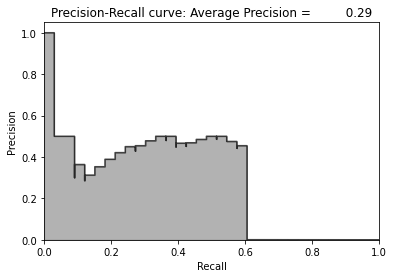

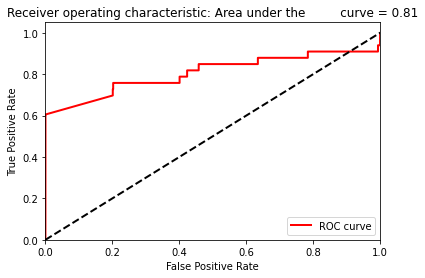

In [64]:
# Plot results
preds, average_precision = plotResults(y_train, 
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

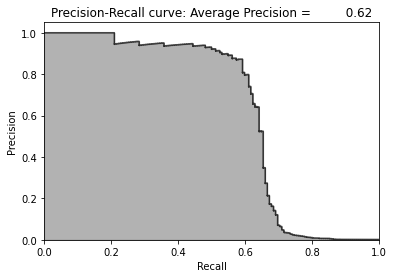

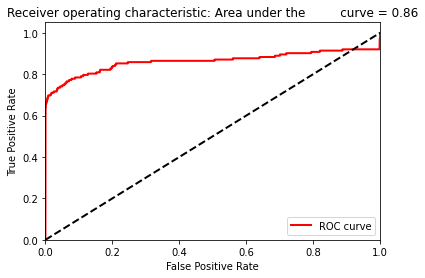

In [65]:

# Evaluate on Test Set
predictions = pd.Series(data=gbm.predict(X_test, 
                num_iteration=gbm.best_iteration), index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [66]:
# Calculate precision at 75% recall
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(f'Precision at 75% recall {round(precision,4)}')

Precision at 75% recall 0.0213


In [67]:
#Unsupervised, Oversampling

# Take the 33 fraudulent cases, duplicate these 100 times and then append them to the training set
oversample_multiplier = 100

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

X_train_oversampled = X_train.copy()
y_train_oversampled = y_train.copy()
X_train_oversampled = X_train_oversampled.append( \
        [X_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)
y_train_oversampled = y_train_oversampled.append( \
        [y_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)

X_train = X_train_oversampled.copy()
y_train = y_train_oversampled.copy()

C:\Users\JMcKay\AppData\Local\Temp\ipykernel_23924\2755606942.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train_oversampled = X_train_oversampled.append( \
C:\Users\JMcKay\AppData\Local\Temp\ipykernel_23924\2755606942.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train_oversampled = y_train_oversampled.append( \


In [68]:
# View shape
X_train.shape, y_train.shape

((193823, 29), (193823,))

In [69]:
# A sparse two-layer overcomplete autoencoder with a linear a linear activation function.  
# Forty nodes in the hidden layer and a dropout of 2%

model = Sequential()
model.add(Dense(units=40, activation='linear', \
                activity_regularizer=regularizers.l1(10e-5), \
                input_dim=29,name='hidden_layer'))
model.add(Dropout(0.02))
model.add(Dense(units=29, activation='linear'))

In [70]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [71]:
# Train model
num_epochs =  5
batch_size = 32

history = model.fit(x=X_train, y=X_train, epochs=num_epochs, 
                    batch_size=batch_size, shuffle=True,
                    validation_split=0.20, verbose=1)

Epoch 1/5
4846/4846 [==============================] - 8s 2ms/step - loss: 0.0873 - accuracy: 0.8514 - val_loss: 0.0075 - val_accuracy: 0.9819
Epoch 2/5
4846/4846 [==============================] - 7s 1ms/step - loss: 0.0183 - accuracy: 0.9259 - val_loss: 0.0624 - val_accuracy: 0.9665
Epoch 3/5
4846/4846 [==============================] - 8s 2ms/step - loss: 0.0175 - accuracy: 0.9262 - val_loss: 0.0314 - val_accuracy: 0.9761
Epoch 4/5
4846/4846 [==============================] - 7s 1ms/step - loss: 0.0170 - accuracy: 0.9255 - val_loss: 0.0394 - val_accuracy: 0.9775
Epoch 5/5
4846/4846 [==============================] - 7s 2ms/step - loss: 0.0170 - accuracy: 0.9261 - val_loss: 0.1743 - val_accuracy: 0.9594


5954/5954 [==============================] - 5s 859us/step


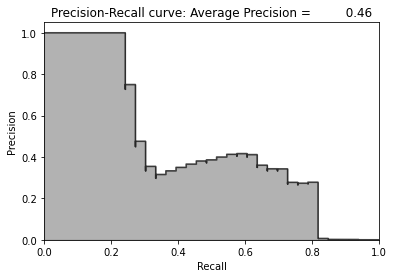

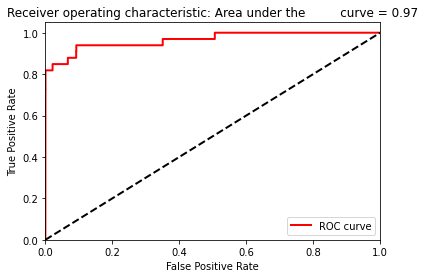

In [72]:
# Evaluate model
predictionsTrain = model.predict(X_train_original, verbose=1)
anomalyScoresAETrain = anomalyScores(X_train_original, predictionsTrain)
preds, average_precision = plotResults(y_train_original, anomalyScoresAETrain, True)

2938/2938 [==============================] - 3s 924us/step


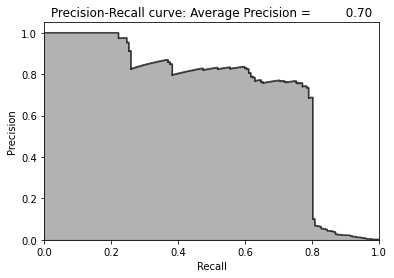

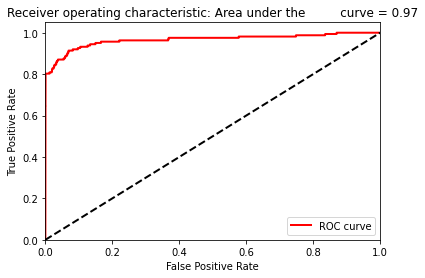

In [73]:

# Evaluate on test set
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, average_precision = plotResults(y_test, anomalyScoresAE, True)

In [74]:
# Calculate precision at 75% recall
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(f'Precision at 75% recall {round(precision,4)}')

Precision at 75% recall 0.7593


In [75]:
# Semisupervised Model
# Combine Hidden Layer of Autoencoder (Learned Features) with Original Feature Set
# Generate hidden layer from autoencoder to pass into supervised model

# Take the representation learned by the autoencode, combine it with the original training set, and feed it into the gradient boosting algorithm.

layer_name = 'hidden_layer'

intermediate_layer_model  = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)#To get the hidden layer, we call Model() class for Keras and gue the get_layer function
intermediate_output_train = intermediate_layer_model.predict(X_train_original) #Store autoencoder representations into dataframes
intermediate_output_test  = intermediate_layer_model.predict(X_test_original)

intermediate_output_trainDF = pd.DataFrame(data=intermediate_output_train, index=X_train_original.index)
intermediate_output_testDF  = pd.DataFrame(data=intermediate_output_test, index=X_test_original.index)

In [76]:
# Add hidden layer dimensions to original dataset
X_train = X_train_original.merge(intermediate_output_trainDF, left_index=True,right_index=True) #Merge hidden layer data with original 
X_test  = X_test_original.merge(intermediate_output_testDF, left_index=True,right_index=True)
y_train = y_train_original.copy()

In [77]:
# Train and Evaluate LightGBM Model with Original + Autoencoder Dimensions
# Boosting on 69 total features - 29 from the original dataset and 40 from the autoencoder
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,  columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=5000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold,num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print(f'Training Log Loss: {round(loglossTraining,4)}')
    print(f'CV Log Loss: {round(loglossCV,4)}' )

c:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0025071
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.0019262
[3]	valid_0's binary_logloss: 0.00195241
[4]	valid_0's binary_logloss: 0.00191496
[5]	valid_0's binary_logloss: 0.00188995
[6]	valid_0's binary_logloss: 0.00174872
[7]	valid_0's binary_logloss: 0.00173647
[8]	valid_0's binary_logloss: 0.00172059
[9]	valid_0's binary_logloss: 0.00170623
[10]	valid_0's binary_logloss: 0.00169333
[11]	valid_0's binary_logloss: 0.00168176
[12]	valid_0's binary_logloss: 0.00167196
[13]	valid_0's binary_logloss: 0.00166177
[14]	valid_0's binary_logloss: 0.00165209
[15]	valid_0's binary_logloss: 0.00164224
[16]	valid_0's binary_logloss: 0.00163186
[17]	valid_0's binary_logloss: 0.00162198
[18]	valid_0's binary_logloss: 0.0016126
[19]	valid_0's binary_logloss: 0.0016036
[20]	valid_0's binary_logloss: 0.001593
[21]	valid_0's binary_logloss: 0.00158488
[22]	valid_0's binary_logloss: 0.00157714
[23]	valid_0's binary_logloss

c:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.00183731
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00212095
[3]	valid_0's binary_logloss: 0.0024774
[4]	valid_0's binary_logloss: 0.00246588
[5]	valid_0's binary_logloss: 0.00245295
[6]	valid_0's binary_logloss: 0.00244165
[7]	valid_0's binary_logloss: 0.00243133
[8]	valid_0's binary_logloss: 0.00243046
[9]	valid_0's binary_logloss: 0.00242026
[10]	valid_0's binary_logloss: 0.00241417
[11]	valid_0's binary_logloss: 0.0024086
[12]	valid_0's binary_logloss: 0.00240223
[13]	valid_0's binary_logloss: 0.00239693
[14]	valid_0's binary_logloss: 0.00238887
[15]	valid_0's binary_logloss: 0.00238448
[16]	valid_0's binary_logloss: 0.00237938
[17]	valid_0's binary_logloss: 0.00238265
[18]	valid_0's binary_logloss: 0.00238041
[19]	valid_0's binary_logloss: 0.00237444
[20]	valid_0's binary_logloss: 0.00237216
[21]	valid_0's binary_logloss: 0.00236692
[22]	valid_0's binary_logloss: 0.00236503
[23]	valid_0's binary_log

c:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.00381823
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00337174
[3]	valid_0's binary_logloss: 0.00373313
[4]	valid_0's binary_logloss: 0.00355613
[5]	valid_0's binary_logloss: 0.00355252
[6]	valid_0's binary_logloss: 0.00348495
[7]	valid_0's binary_logloss: 0.00348198
[8]	valid_0's binary_logloss: 0.0034789
[9]	valid_0's binary_logloss: 0.00347582
[10]	valid_0's binary_logloss: 0.00346432
[11]	valid_0's binary_logloss: 0.00346026
[12]	valid_0's binary_logloss: 0.00344433
[13]	valid_0's binary_logloss: 0.00343373
[14]	valid_0's binary_logloss: 0.00343088
[15]	valid_0's binary_logloss: 0.00342241
[16]	valid_0's binary_logloss: 0.00334817
[17]	valid_0's binary_logloss: 0.00306125
[18]	valid_0's binary_logloss: 0.00278153
[19]	valid_0's binary_logloss: 0.00271818
[20]	valid_0's binary_logloss: 0.00271249
[21]	valid_0's binary_logloss: 0.00269995
[22]	valid_0's binary_logloss: 0.00268822
[23]	valid_0's binary_lo

c:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.00331495
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00328953
[3]	valid_0's binary_logloss: 0.00285833
[4]	valid_0's binary_logloss: 0.00238657
[5]	valid_0's binary_logloss: 0.0022498
[6]	valid_0's binary_logloss: 0.00221704
[7]	valid_0's binary_logloss: 0.00218667
[8]	valid_0's binary_logloss: 0.00193211
[9]	valid_0's binary_logloss: 0.00185109
[10]	valid_0's binary_logloss: 0.0018149
[11]	valid_0's binary_logloss: 0.00178974
[12]	valid_0's binary_logloss: 0.00177029
[13]	valid_0's binary_logloss: 0.0017539
[14]	valid_0's binary_logloss: 0.00174171
[15]	valid_0's binary_logloss: 0.00172895
[16]	valid_0's binary_logloss: 0.00171763
[17]	valid_0's binary_logloss: 0.00171062
[18]	valid_0's binary_logloss: 0.001696
[19]	valid_0's binary_logloss: 0.0016908
[20]	valid_0's binary_logloss: 0.00168614
[21]	valid_0's binary_logloss: 0.00168124
[22]	valid_0's binary_logloss: 0.00167122
[23]	valid_0's binary_logloss

c:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.00216737
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.0021098
[3]	valid_0's binary_logloss: 0.00205962
[4]	valid_0's binary_logloss: 0.00571889
[5]	valid_0's binary_logloss: 0.00534984
[6]	valid_0's binary_logloss: 0.00436985
[7]	valid_0's binary_logloss: 0.00240996
[8]	valid_0's binary_logloss: 0.00242346
[9]	valid_0's binary_logloss: 0.00240155
[10]	valid_0's binary_logloss: 0.00238356
[11]	valid_0's binary_logloss: 0.00237688
[12]	valid_0's binary_logloss: 0.0023488
[13]	valid_0's binary_logloss: 0.00232632
[14]	valid_0's binary_logloss: 0.00230341
[15]	valid_0's binary_logloss: 0.00228223
[16]	valid_0's binary_logloss: 0.00226456
[17]	valid_0's binary_logloss: 0.00224797
[18]	valid_0's binary_logloss: 0.002231
[19]	valid_0's binary_logloss: 0.00221646
[20]	valid_0's binary_logloss: 0.00220006
[21]	valid_0's binary_logloss: 0.00218551
[22]	valid_0's binary_logloss: 0.00223686
[23]	valid_0's binary_loglo

In [78]:
# Print results of the combined 69 features
loglossLightGBMGradientBoosting = log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print(f'LightGBM Gradient Boosting Log Loss: {round(loglossLightGBMGradientBoosting,4)}')

LightGBM Gradient Boosting Log Loss: 0.0017


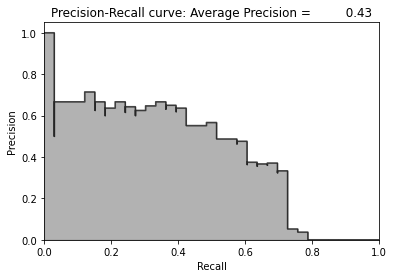

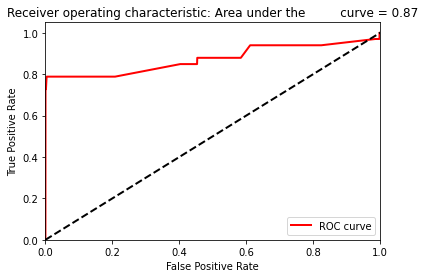

In [79]:
# Evaluate results
preds, average_precision = plotResults(y_train, predictionsBasedOnKFolds.loc[:,'prediction'], True)

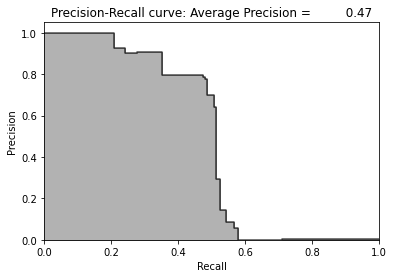

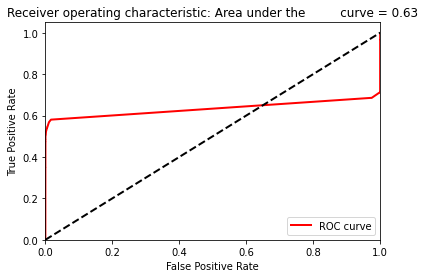

In [80]:
# Evaluate results on test set
predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration),index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [81]:
# Calculate precision at 75% recall
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(f'{round(precision,4)}')

0.0013


In [82]:
# Analyze most important features
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), index=X_train.columns,columns=['featImportance'])
featuresImportance = featuresImportance/featuresImportance.sum()
featuresImportance.sort_values(by='featImportance', ascending=False,inplace=True)
featuresImportance[:20]

,featImportance
3,0.083333
V13,0.083333
13,0.083333
10,0.083333
V7,0.083333
V1,0.055556
V12,0.055556
Amount,0.055556
V9,0.055556
V8,0.055556
